## Summary
Records of over 250,000 police pull-overs in the state of Vermont between the years 2010-2015 were analyzed alongside various features such as driver demographics, location information, and datetime information. Findings:


## 1. Introduction
### Problem statement:
   In today’s society, there is an increasing dialogue around policing and community-police relations. As a result, it is increasingly important to ensure officers are acting justly in routine police pull-overs. Using features such as the time of an incident, date, race, and which police force is responsible for the citation, one may be able to predict or anticipate the outcome of a certain traffic incident.
   
   This problem is important because if there is a bias within the police force, it can possibly be narrowed down to a specific department and corrected. Additionally, if a certain instance is common and predictable through specific features, it can help a police force focus on proper preventative measures. Through an accurate predictive model, this could be useful as a way to make sure police departments are accurately and unbiasedly giving proper citations to perpetrators, which would result in a more just and fortified law enforcement, and potentially a better relationship between the community and police. 

### The dataset:
   I acquired the dataset from Enigma Public, which is a website dedicated to providing information to the open public derived from local, state, and federal governments as well as universities, NGOs, and nonprofits. The direct link to the dataset is as follows: https://public.enigma.com/datasets/vermont/a34af967-056f-48e6-8838-c511d795f3ec 
   
   The dataset contains traffic stop outcomes from 14 police departments in Vermont along with other relevant stop data such as demographics and incident specific information collected between the years 2010 and 2015. 
   
   During the data exploration phase, I saw a clear bias and skew in data toward certain features. For example, approximately 95% of our data from ‘driver_race’ consisted of white people, whereas the remaining 5% involved people of at least three other races. This particular imbalance is logical, since the state of Vermont as a whole has an overwhelming population of cauasian descent according to the U.S. Census Bureau from 2018. However, the most important observation that I made was when I uncovered a large class imbalance in ‘stop_outcome’; a decision was made to drop the rare classes ‘Arrest for Violation’, ‘Warrant Arrest’, and ‘Verbal Warning’, which only accounted for 1.19% of the data. As a result, I turned the classification into a binary problem and kept ‘Written Warning’ (170,980) and ‘Citation’ (106,638), as these were the most prevalent categories in the class. 

### Questions of interest:
   The following questions guided my data exploration and analysis:
   - How does stop outcome vary with driver age, race, and gender? Are there significant differences among groups?
   - Is there consistency across Vermont police departments in number of police pull overs and stop outcome? Does a specific police department make more stops than others?
   - Trends in stop outcome over time: time of day, day of week, month of year, yearly averages.
   - Is there a consistent relationship between violation type and stop outcome? We would expect this.


## 2. Data wrangling

In [2]:
# import modules
import pandas as pd
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import time

# display plots inline 
%matplotlib inline

In [3]:
# import the raw dataset 
data = pd.read_csv('dataProject.csv')

# inspect the dataset
data.head()

,id,state,stop_date,stop_time,stop_datetime,location_raw,county_name,county_fips,fine_grained_location,police_department,...,driver_race,violation_raw,violation,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,officer_id
0,VT-2010-00001,VT,7/1/10,0:10,2010-07-01T00:10:00,East Montpelier,Washington County,50023.0,COUNTY RD,MIDDLESEX VSP,...,White,Moving Violation,Moving violation,False,No Search Conducted,NaN,False,Citation,False,-1.562157e+09
1,VT-2010-00002,VT,7/1/10,0:10,2010-07-01T00:10:00,NaN,NaN,NaN,COUNTY RD; Fitch Road,MIDDLESEX VSP,...,White,Externally Generated Stop,Other,False,No Search Conducted,NaN,False,Arrest for Violation,True,-1.562157e+09
2,VT-2010-00003,VT,7/1/10,0:10,2010-07-01T00:10:00,NaN,NaN,NaN,COUNTY RD; Fitch Road,MIDDLESEX VSP,...,White,Externally Generated Stop,Other,False,No Search Conducted,NaN,False,Arrest for Violation,True,-1.562157e+09
3,VT-2010-00004,VT,7/1/10,0:11,2010-07-01T00:11:00,Whiting,Addison County,50001.0,N MAIN ST,NEW HAVEN VSP,...,White,Moving Violation,Moving violation,False,No Search Conducted,NaN,False,Arrest for Violation,True,-3.126844e+08
4,VT-2010-00005,VT,7/1/10,0:35,2010-07-01T00:35:00,Hardwick,Caledonia County,50005.0,i91 nb mm 62,ROYALTON VSP,...,White,Moving Violation,Moving violation,False,No Search Conducted,NaN,False,Written Warning,False,9.225661e+08


In [3]:
# view count of null values 
data.isnull().sum()

id                            0
state                         0
stop_date                     0
stop_time                     0
stop_datetime                 0
location_raw                694
county_name                 705
county_fips                 705
fine_grained_location       347
police_department             0
driver_gender              1712
driver_age_raw             1171
driver_age                 1286
driver_race_raw            3984
driver_race                4817
violation_raw              2178
violation                  2178
search_conducted              0
search_type_raw            2240
search_type              279866
contraband_found             34
stop_outcome               2325
is_arrested                   0
officer_id                   12
dtype: int64

### 2a. Dropping null values
- A decision is made to drop 'search_type', 'stop_datetime', and 'raw' attributes (with two exceptions listed below) due to redundancy and high null value counts.

- 'violation_raw' and 'search_type_raw' were kept because the data was more descriptive in these fields compared to the "cleaned" fields

- 'officer_id' was dropped, as there is too many individual officers to be accounted for, and this information would not be predictive in classification.

- 'is_arrested' was dropped, as it is similar to the stop_outcome variable I am predicting. I chose to use stop_outcome as the label, as it has more detail in the outcome of the stop (such as if they were given a warning or a citation if they weren't arrested).

- 'search_conducted' was dropped as 'search_type_raw' has the same information in more detail.

- 'County_name', 'location_raw', and 'fine_grained_location' were dropped because police department encompasses all of this information already

- 'state' was dropped, as all the instances occur in the same state.

- 'id' was dropped because it does not provide any helpful information

In [4]:
# drop the mentioned columns
data_drop = data.drop(['state', 'stop_datetime', 'county_fips', 'driver_age_raw', 'driver_race_raw','violation', 'search_conducted', 'search_type', 'is_arrested', 'officer_id', 'fine_grained_location','county_name','location_raw', 'id'], axis=1)

In [5]:
# check the null values of columns we have left
#data_drop.isnull().sum()

- to account for the null values, list wise deletion is chosen: everywhere a blank field is encountered, the entire record is deleted. 

In [6]:
# list wise deletion
data_drop = data_drop.dropna(axis=0)

# verify nulls are gone
#data_drop.isnull().sum()

In [7]:
# view the columns
data_drop.columns

# rename the raw columns 
data_drop = data_drop.rename(columns={"violation_raw": "violation", "search_type_raw": "search_type"})

In [8]:
# verify the types of each column are appropriate
#data_drop.info()

### 2b. Primary feature engineering
 - 'stop_date' and 'stop_time' are converted to datetime objects instead of objects. 
 - weekday, month, and year columns are engineered from datetime column to gain more information
 - 'stop_time' is condensed from HH:MM to just hour to reduce unneeded specificity

In [9]:
# change date time variables from objects to date time objects
data_drop['stop_date'] = pd.to_datetime(data_drop['stop_date'], infer_datetime_format=True)
data_drop['stop_time'] = pd.to_datetime(data_drop['stop_time'], infer_datetime_format=True)

In [10]:
# add a weekday, month, and year column to replace 'stop_date'
# feature engineering done to gain more information on the date
data_drop['weekday'] = data_drop['stop_date'].dt.dayofweek
data_drop['month'] = data_drop['stop_date'].dt.month
data_drop['year'] = data_drop['stop_date'].dt.year

# delete stop_date since it is no longer needed 
#data_drop = data_drop.drop(['stop_date'], axis=1)

In [11]:
# change stop_time to be the hour in which the stop occured instead of the specific hour and minute it occured 
# to decrease specificity
data_drop['stop_time'] = data_drop['stop_time'].dt.hour

In [12]:
# dataset is now cleaned... save the cleaned version 
data_clean = data_drop.copy()

## 3. Initial data exploration
### 3a. Univariate Analysis 
- univariate anaylsis is done by EDA to determine if variables should be further engineered or modified

### Investigating the target variable: 'stop_outcome'
**Insights:**
- A large class imbalance is seen here, so a decision is made to drop the rare classes and turn the classification into a binary problem. I will keep only 'written warning' and 'citation' outcomes, as these are the most prevalant in the data

In [13]:
data_clean.stop_outcome.value_counts(normalize=True)

Written Warning         0.609272
Citation                0.378643
Arrest for Violation    0.011771
Warrant Arrest          0.000277
Verbal Warning          0.000036
Name: stop_outcome, dtype: float64

In [13]:
# drop the records which do not belong to the two specified classes
data_cut = data_clean[data_clean['stop_outcome'].isin(['Written Warning', 'Citation'])]

# verify there is enough data remaining after reduction
#data_cut.info()

# look at the class balance now
data_cut['stop_outcome'].value_counts(normalize=True)

Written Warning    0.616725
Citation           0.383275
Name: stop_outcome, dtype: float64

### Investigating driver demographics (age, gender, race) ###
**Insights:**
 - Driver age contained outliers above 90 years of age; these were deleted
 - Driver race is extremely skewed toward White, as expected due to location. Race should be converted to dummy variables for further analysis
 - Gender is somewhat balanced, and should be hot encoded for further analysis

White       0.956872
Black       0.020196
Asian       0.012665
Hispanic    0.009315
Other       0.000953
Name: driver_race, dtype: float64

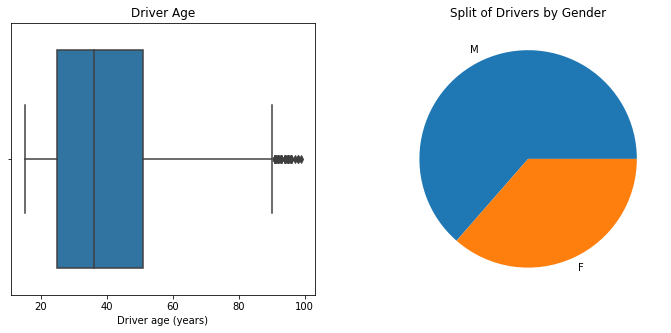

In [17]:
f, axs = plt.subplots(1,2, figsize=(12,5))
_ = plt.subplot(1,2,1)
_ = sns.boxplot(x=data_cut['driver_age'])
_ = plt.title('Driver Age')
_ = plt.xlabel('Driver age (years)')
_ = plt.subplot(1,2,2)
_ = data_cut['driver_gender'].value_counts(normalize=True).plot(kind="pie")
_ = plt.title('Split of Drivers by Gender')
_ = plt.ylabel("")
data_cut['driver_race'].value_counts(normalize=True)

In [14]:
# remove age outliers
q1 = data_cut['driver_age'].quantile(0.25)
q3 = data_cut['driver_age'].quantile(0.75)
IQR = q3 - q1
filter = (data_cut['driver_age'] >= q1 - 1.5 * IQR) & (data_clean['driver_age'] <= q3 + 1.5 *IQR)
data_cut = data_cut.loc[filter]  
data_cut.shape

(270668, 13)

In [15]:
# I want a new dataframe that doesnt have dummy variables... making that now 
df_nodummy = data_cut.copy()

In [16]:
# convert race to dummy categoricals
dummies = pd.get_dummies(data_cut['driver_race'])
data_cut = pd.concat([data_cut, dummies], axis=1)
# drop the old column
#data_cut = data_cut.drop('driver_race', axis=1)

# convert gender to hot encoding: male = 1, female = 0
data_cut['driver_gender'] = (data_cut['driver_gender'] == 'M').astype(int)

### Investigating time variables (weekday, month, year, stop_time) ###
**Insights:**
 - weekday, month, and year are all fairly evenly distributed
 - stop time was log transformed to reduce skew, and an exponential distribution appears to emerge.
 - I added '1' to weekday and hour columns to account for 0 indexing

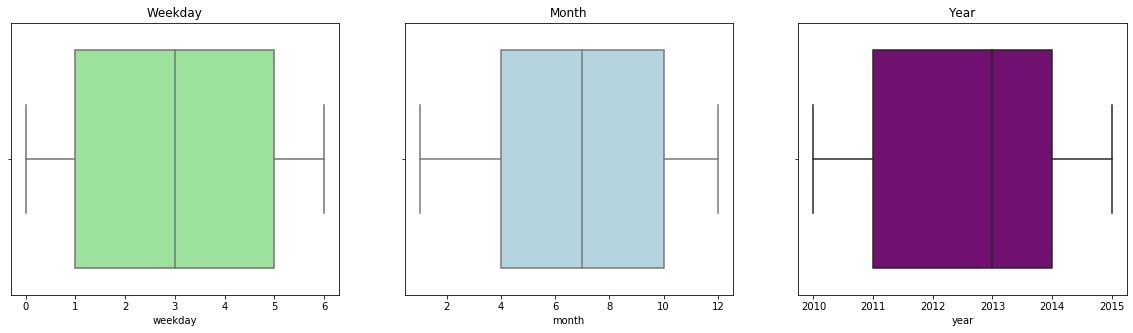

In [18]:
f, axs = plt.subplots(1,3, figsize=(20,5))
_ = plt.subplot(1,3,1)
_ = sns.boxplot(x=data_cut['weekday'], color="lightgreen")
_ = plt.title('Weekday')
_ = plt.subplot(1,3,2)
_ = sns.boxplot(x=data_cut['month'], color="lightblue")
_ = plt.title('Month')
_ = plt.subplot(1,3,3)
_ = sns.boxplot(x=data_cut['year'], color="purple")
_ = plt.title('Year')

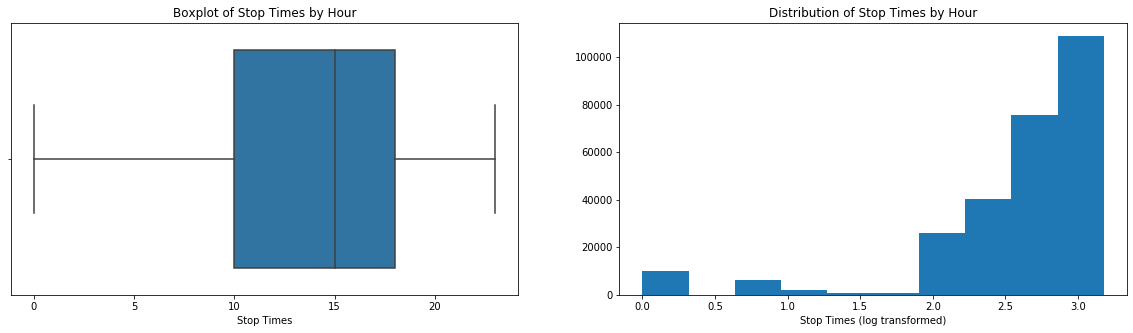

In [19]:
f, axs = plt.subplots(1,2, figsize=(20,5))
_ = plt.subplot(1,2,1)
_ = sns.boxplot(data_cut['stop_time'])
_ = plt.title('Boxplot of Stop Times by Hour')
_ = plt.xlabel('Stop Times')
_ = plt.subplot(1,2,2)
logged = np.log((data_cut['stop_time']) + 1)
_ = plt.hist(logged, bins=10)
_ = plt.title('Distribution of Stop Times by Hour')
_ = plt.xlabel('Stop Times (log transformed)')

In [17]:
data_cut['weekday'] = data_cut['weekday'] + 1
data_cut['stop_time'] = data_cut['stop_time'] + 1

In [18]:
# correcting data_nodummy
df_nodummy['weekday'] = df_nodummy['weekday'] + 1
df_nodummy['stop_time'] = df_nodummy['stop_time'] + 1

### Investigating traffic stop details (violation, search_type, contraband_found, police_department) ###
**Insights:**
- Two outlier records were found and deleted from the violation column. The violation column is dominated by moving violation, which is to be expected, as this is the most common form of routine police pull overs.
- Records from 'VSP HQ- BCI/SIU/NIU' police department were deleted since less than 1% of records belonged to this group.
- 1 record from search type was '(Winooski) Passgr Srch', and it was deleted. The majority of data in the field belongs to 'no search conducted'
- Contraband_found was heavily imbalanced, so a decision was made to delete it based on infrequency.
- Police_department and violation were converted to dummy variables for further analysis 
- Search_type was converted to be a binary choice with 1 being no search conducted, and 0 being search conducted. This decision was made due to the large majority of data belonging to one class. 

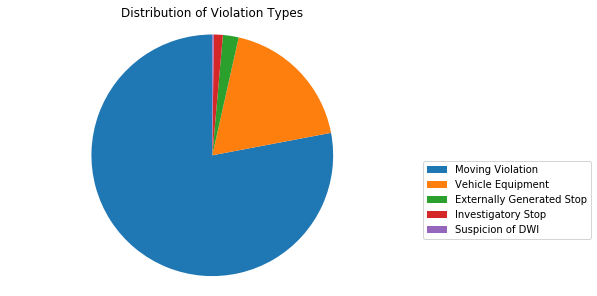

In [240]:
data_cut['violation'].value_counts()

# take out winooski records (2) due to it being an outlier
data_cut = data_cut[data_cut.violation != '(Winooski) Be On Look Rqst']
data_cut = data_cut[data_cut.violation != '(Winooski) Mtr Vhc Vltn']
#data_cut['violation'].value_counts()

# Pie chart of violation types
labels = ['Moving Violation', 'Vehicle Equipment', 'Externally Generated Stop', 
          'Investigatory Stop', 'Suspicion of DWI']
sizes = [77.9, 18.5, 2.1, 1.2, .2]

  
fig1, ax1 = plt.subplots()
ax1.pie(sizes,
        startangle=90, )

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title('Distribution of Violation Types')
plt.legend(labels=labels,loc='upper left', bbox_to_anchor=(1,0.5))
plt.show()

In [19]:
# take out winooski records (2) due to it being an outlier in the df_nodummy
df_nodummy = df_nodummy[df_nodummy.violation != '(Winooski) Be On Look Rqst']
df_nodummy = df_nodummy[df_nodummy.violation != '(Winooski) Mtr Vhc Vltn']

In [242]:
# convert violation to dummy variables 
dummies = pd.get_dummies(data_cut['violation'])
data_cut = pd.concat([data_cut, dummies], axis=1)

# drop the old column
#data_cut = data_cut.drop('violation', axis=1)

In [243]:
data_cut['police_department'].value_counts(normalize=True)
# take out 'VSP HQ- BCI/SIU/NIU' records (< 1%) due to it being an outlier
data_cut = data_cut[data_cut.police_department != 'VSP HQ- BCI/SIU/NIU']
data_cut.police_department.value_counts(normalize=True)

MIDDLESEX VSP                     0.099830
ROYALTON VSP                      0.093591
WILLISTON VSP                     0.086768
NEW HAVEN VSP                     0.083973
VSP HEADQUARTERS - FIELD FORCE    0.083958
ROCKINGHAM VSP                    0.082598
RUTLAND VSP                       0.080166
ST ALBANS VSP                     0.075486
BRADFORD VSP                      0.075364
SHAFTSBURY VSP                    0.075080
BRATTLEBORO VSP                   0.072330
ST JOHNSBURY VSP                  0.054103
DERBY VSP                         0.036753
Name: police_department, dtype: float64

In [20]:
# take out 'VSP HQ- BCI/SIU/NIU' records (< 1%) due to it being an outlier in df_nodummy
df_nodummy = df_nodummy[df_nodummy.police_department != 'VSP HQ- BCI/SIU/NIU']

In [245]:
# convert the police department into dummy variables
dummies = pd.get_dummies(data_cut['police_department'])
data_cut = pd.concat([data_cut, dummies], axis=1)

# drop the old column
#data_cut = data_cut.drop('police_department', axis=1)

In [246]:
data_cut['search_type'].value_counts()
# take out winooski due to outlier 
data_cut = data_cut[data_cut.search_type != '(Winooski) Passgr Srch']
data_cut['search_type'].value_counts()

No Search Conducted               268186
Consent Search-Probable Cause       1611
Consent Search-Rsnbl Suspicion       646
Search with Warrant                   95
Name: search_type, dtype: int64

In [21]:
# take out winooski due to outlier in df_dummy
df_nodummy = df_nodummy[df_nodummy.search_type != '(Winooski) Passgr Srch']

In [248]:
# as most data comes from no search conducted, we will simplify this column to be binary for if there is search conducted or not
# hot encoding: no search = 1, other = 0
data_cut['search_type'] = (data_cut['search_type'] == 'No Search Conducted').astype(int)

In [22]:
# as most data comes from no search conducted, we will simplify this column to be binary for if there is search conducted or not
# hot encoding: no search = 1, other = 0 (same for df_nodummy)
df_nodummy['search_type'] = (df_nodummy['search_type'] == 'No Search Conducted').astype(int)

False    0.993424
True     0.006576
Name: contraband_found, dtype: float64

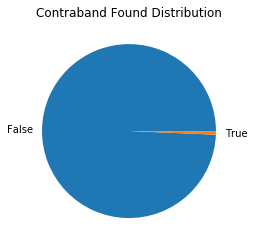

In [35]:
_ = data_cut['contraband_found'].value_counts(normalize=True).plot(kind="pie")
_ = plt.title('Contraband Found Distribution')
_ = plt.ylabel("")
data_cut['contraband_found'].value_counts(normalize=True)

In [250]:
#as a majority of the stops didn't have contrabound, we decided to drop this variable.
data_cut = data_cut.drop(['contraband_found'], axis=1)

In [23]:
#as a majority of the stops didn't have contrabound, we decided to drop this variable. (for df_nodummy)
df_nodummy = df_nodummy.drop(['contraband_found'], axis=1)

#### At this point, all of the data cleaning and wrangling has been completed, and thus the final dataset can be saved as data_final

In [252]:
data_final = data_cut.copy()

In [253]:
data_final.columns

Index(['stop_date', 'stop_time', 'police_department', 'driver_gender',
       'driver_age', 'driver_race', 'violation', 'search_type', 'stop_outcome',
       'weekday', 'month', 'year', 'Asian', 'Black', 'Hispanic', 'Other',
       'White', 'Externally Generated Stop', 'Investigatory Stop',
       'Moving Violation', 'Suspicion of DWI', 'Vehicle Equipment',
       'BRADFORD VSP', 'BRATTLEBORO VSP', 'DERBY VSP', 'MIDDLESEX VSP',
       'NEW HAVEN VSP', 'ROCKINGHAM VSP', 'ROYALTON VSP', 'RUTLAND VSP',
       'SHAFTSBURY VSP', 'ST ALBANS VSP', 'ST JOHNSBURY VSP',
       'VSP HEADQUARTERS - FIELD FORCE', 'WILLISTON VSP'],
      dtype='object')

## 4. Targeted EDA
### 4a. Stop outcome variation with driver demographics
To understand how stop outcome varies with driver demographics, many angles are considered:
1. stop outcome data is plotted for male and female groups; the same data is plotted along a yearly axis to see if the trend is consistent year after year;
2. stop outcome data is compared among driver race groups; the same data is plotted after being grouped by police department to spot any inconsistencies or possible racial bias among differing stations.
3. Age is split into 3 groups: early drivers (high risk, 0-25), middle aged drivers (lowest risk, 25-50), older drivers (medium risk, 50+) and then stop outcome trends are compared among age groups 

#### 1. Male vs Female

In [254]:
data_vis = data_final.copy()
data_vis['driver_gender'] = data_vis['driver_gender'].apply({1:'Male', 0:'Female'}.get)

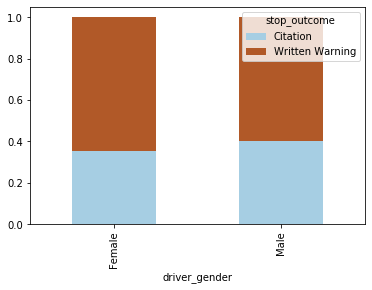

In [32]:
# male = 1, female = 0
outcome_by_gender = data_vis.groupby('driver_gender').stop_outcome.value_counts(normalize=True).unstack()
_ = outcome_by_gender.plot(kind="bar", stacked=True, cmap="Paired")

Both genders receive written warnings more often, but females receive written warning slightly more often than males on average.

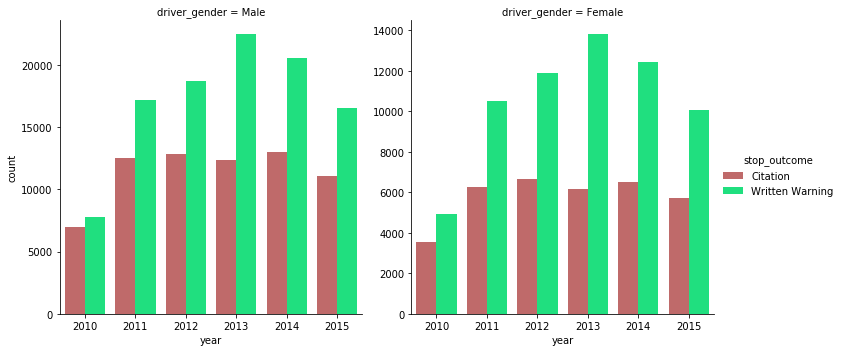

In [33]:
# look at the pattern in citation: written warnings 
# would be better if it was normalized... sharey=false for now
_ = sns.catplot(x='year', hue='stop_outcome',  col='driver_gender', data=data_vis, kind="count", 
                estimator=lambda : len(x) / len(data_final) * 100, palette=['indianred','springgreen'], sharey=False)


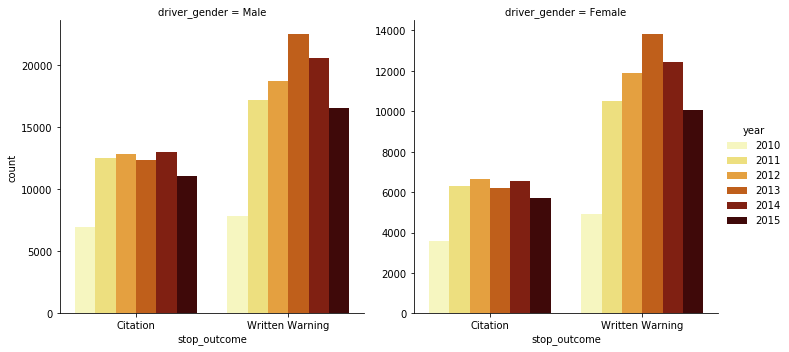

In [34]:
# look at the patterns across years by gender 
_ = sns.catplot(x='stop_outcome', hue='year',  col='driver_gender', data=data_vis, kind="count", 
                estimator=lambda : len(x) / len(data_final) * 100, sharey=False, palette="afmhot_r")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1034c35f8>,
      dtype=object)

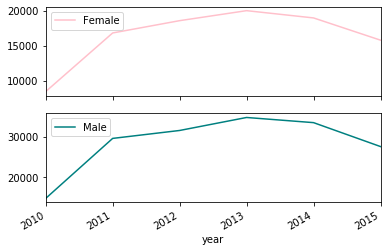

In [35]:
# investigate the amount of data present for females and males across years
data_vis.groupby('year').driver_gender.value_counts().unstack().plot(kind='line', subplots=True, color=['pink', 'teal'])

The amount of citations received seems to stay consistent across years in both males and females.
The written warnings increase heavily after 2010, with what seems to be a spike in 2013. However, as shown in the line graph above, this is probably due to the differing amounts of data available for each year. (2013 had the most data, with 2010 having the least)

While comparing citation:written warning ratios within female and male groups, it appears that the ratio is higher in males than in females.

#### 2. Driver race

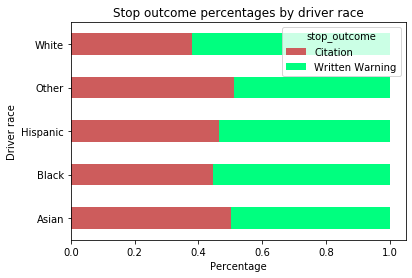

In [36]:
# outcome by driver race normalized
outcome_by_race = data_final.groupby('driver_race').stop_outcome.value_counts(normalize=True).unstack()
_ = outcome_by_race.plot(kind="barh", stacked=True, colors=['indianred', 'springgreen'])
_ = plt.title('Stop outcome percentages by driver race')
_ = plt.xlabel('Percentage')
_ = plt.ylabel('Driver race')

From this graph alone, we can see that whites are the least likely to receive a citation when compared amongst other races. However, the skew in data must be acknowledged, as most of the data belongs to the white class.

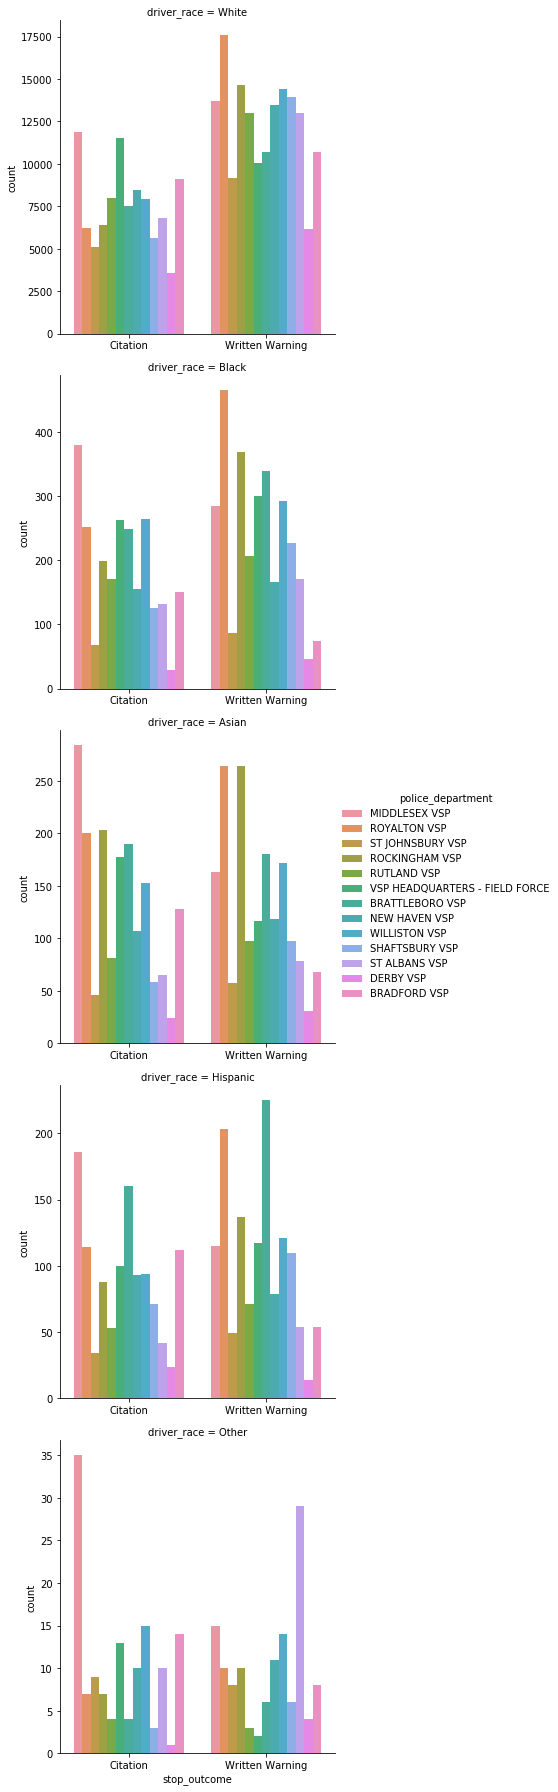

In [37]:
# outcome by driver race and police department
_ = sns.catplot(x='stop_outcome', hue='police_department', col="driver_race", data=data_final, kind="count",\
                col_wrap=True, sharey=False, sharex=False, legend=True)

The first column stands out here, as there appears to be more citations than written warnings in every race category except white for this column. Because of this, I will investigate this police department (Middlesex vsp) more closely.

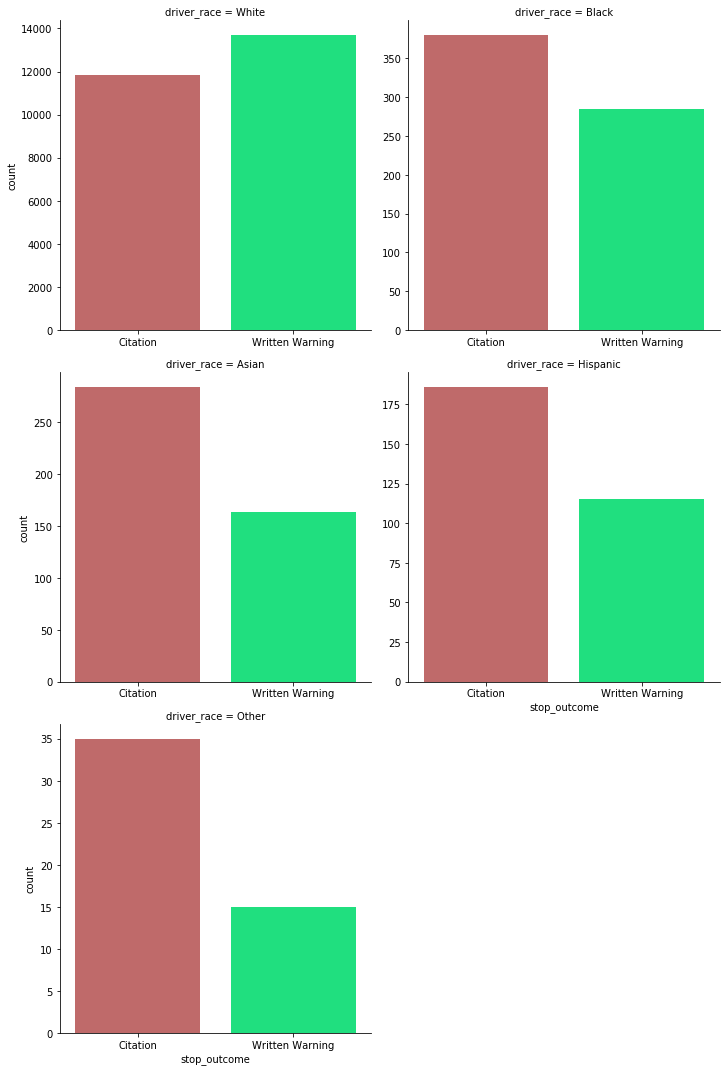

In [38]:
# what is the count of data across police departments? is this discrepancy due to lack of data?
data_final.police_department.value_counts() #no

# what about by race?
data_final.groupby('driver_race').police_department.value_counts() #no

# ok... so look at a graph with only middlesex vsp by race and stop outcome
middlesex = data_final[data_final.police_department == 'MIDDLESEX VSP']
_ = sns.catplot(x='stop_outcome', col="driver_race", data=middlesex, kind="count",\
                col_wrap=2, sharey=False, sharex=False, palette=['indianred', 'springgreen'])

This investigation confirms that there appears to be a potential bias in the middlesex vsp police department!

#### 3. Driver age
3. Age is split into 3 groups: early drivers (high risk, 0-25), middle aged drivers (lowest risk, 25-50), older drivers (medium risk, 50+) and then stop outcome trends are compared among age groups 

In [259]:
bins= [0,25,50,90]
labels = ['early','middle','late']
data_vis['ageGroup'] = pd.cut(data_vis['driver_age'], bins=bins, labels=labels, right=False)

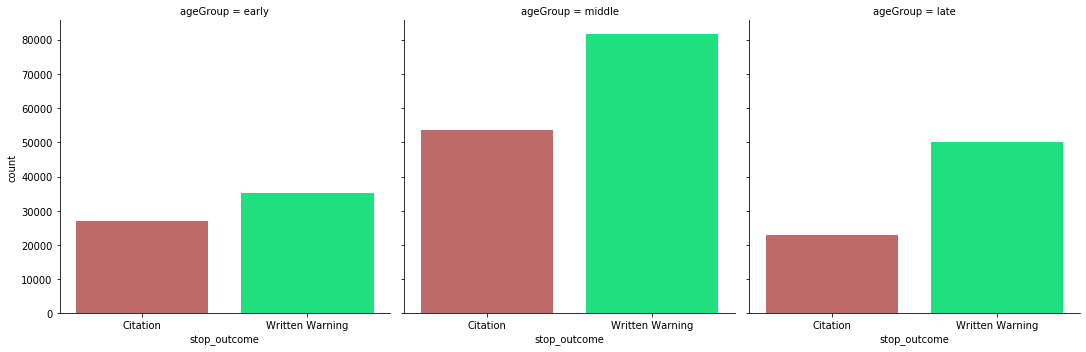

In [40]:
# show stop outcome by age group 
_ = sns.catplot(x='stop_outcome', col='ageGroup', data=data_vis, kind="count", palette=['indianred', 'springgreen'])

All three age groups get more written warnings than citations, but early drivers have a lower written warning : citation ratio, indicating they receive slightly more citations than other age groups.

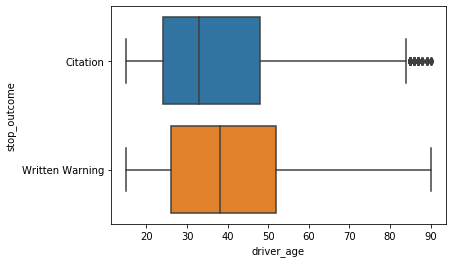

In [41]:
_ = sns.boxplot(x='driver_age', y="stop_outcome",data=data_vis)

The boxplot of original age data confirms this idea: older drivers get more written warnings on average than younger drivers. Additionally, it seems to be very rare for a driver in the 'late' age group category to receive a citation. 

### 4b. Stop outcome variation with time data
To understand how stop outcome varies with time data, increasingly larger time intervals are considered:
1. stop outcome data is plotted against stop_time to see if there is a notable difference in outcome depending on the time of day.
2. stop outcome data is compared across weekday to uncover any patterns that may occur on a day to day basis. 
3. stop outcome data is compared across months to determine if stop outcome distributions are the same each month; 
4. stop outcome data is compared year to year to find out if trends have changed each year or stayed generally the same.

#### 1. Hourly 

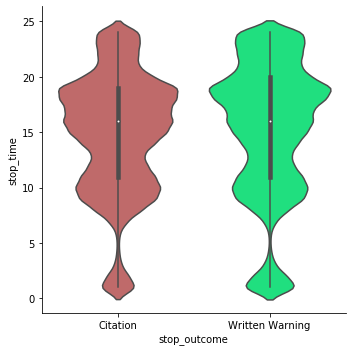

In [42]:
_ = sns.catplot(x='stop_outcome', y='stop_time', data=data_final, kind='violin', palette=['indianred','springgreen'])

From this graph we can see that most traffic stops occur after noon and before 8pm. In this region of high activity, we see more citations than written warnings. However, in the early morning and late evening, the trend reverses and we see more written warnings than citations. 

#### 2. Daily

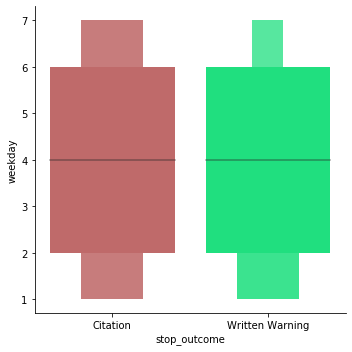

In [43]:
_ = sns.catplot(x='stop_outcome', y='weekday', data=data_final, kind='boxen', palette=['indianred','springgreen'])

As expected, most of the traffic stops occur in the weekdays; this makes sense as people often travel more often during the week than during the weekend. 

On Saturdays, more citations are given out than written warnings, whereas the rest of the week is distributed equally.

#### 3. Monthly

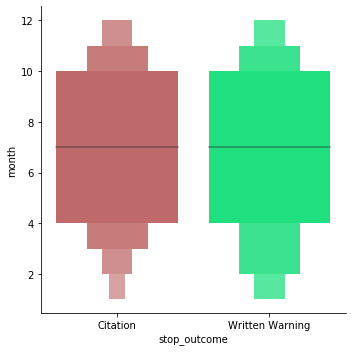

In [44]:
_ = sns.catplot(x='stop_outcome', y='month', data=data_final, kind='boxen', palette=['indianred','springgreen'])

Here we see that most of the data comes from April-October. 
- In early months, more written warnings are given out than citations.
- Mid year we see an equal distribution of citations and written warnings
- Late year sees a decrease in overall data, but the split between citations and written warnings remains about equal

#### 4. Annually

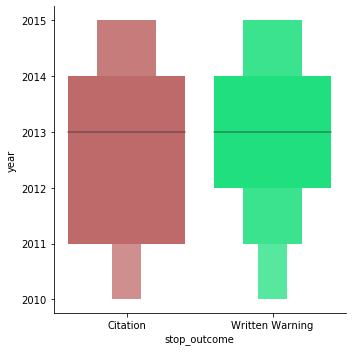

In [45]:
_ = sns.catplot(x='stop_outcome', y='year', data=data_final, kind='boxen', palette=['indianred','springgreen'])

Annual data is distributed equally except in 2011, where we see more citations than written warnings.

### 4b. Stop outcome variation with traffic stop variables
To understand how stop outcome varies with traffic stop variables, 'violation' and 'search_type' are plotted against stop outcome. 

#### 1. Violation type 

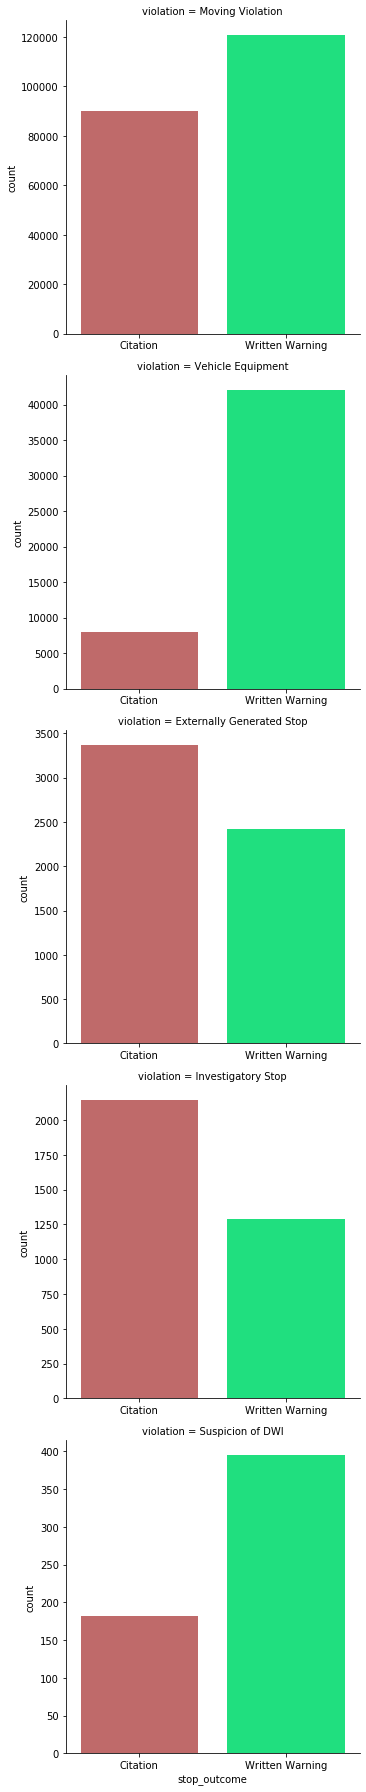

In [46]:
_ = sns.catplot(x='stop_outcome', col='violation', data=data_final, sharey=False, sharex=False, kind='count', palette=['indianred','springgreen'], col_wrap=True, legend=True)



In each of these categories except two, written warnings are more numerous than citations. However, in 'investigatory stop' and 'externally generated stop', this pattern did not hold true and more citations were observed than written warnings. 
- An externally generated stop can be exampled by an accident or a 911 call for reckless driving, so it seems reasonable that more citations are given in this category.
- In an investigatory stop, the officer must have reasonable suspicion that the person is involved in illegal activity, so this also makes sense for a higher citation rate.

#### 2. Search type

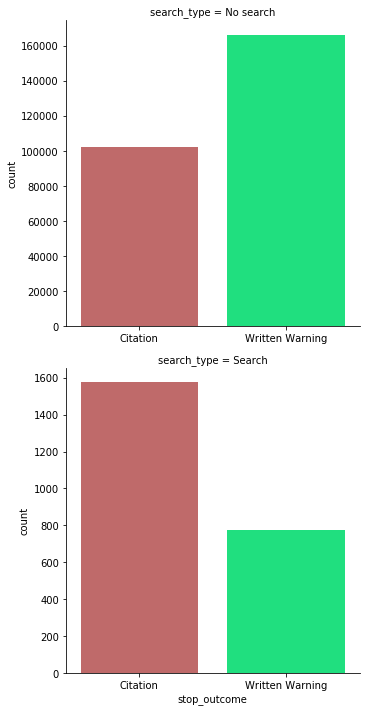

In [47]:
# no search is 1, search is 0
data_vis['search_type'] = data_vis['search_type'].apply({1:'No search', 0:'Search'}.get)
_ = sns.catplot(x='stop_outcome', col='search_type', data=data_vis, sharey=False, sharex=False, kind='count', palette=['indianred','springgreen'], col_wrap=True, legend=True)


We see a much higher rate of citations when a search was conducted, which is to be expected since the officer must have reasonable conviction to search. Because of this, I may want to delete search_type from the dataframe before building a model. 

## Statistical Analysis 

#### 1. Chi squared tests of independence

Driver gender vs stop outcome 
    
    Ho: Driver gender and stop outcome are independent
    Ha: Driver gender and stop outcome are dependent

In [214]:
# first need contingency table 
data_vis = df_nodummy.copy()
data_vis['driver_gender'] = data_vis['driver_gender'].apply({1:'Male', 0:'Female'}.get)
data_vis['stop_outcome'] = data_vis['stop_outcome'].apply({1:'Written warning', 0:'Citation'}.get)
pd.crosstab(data_vis.driver_gender, data_vis.stop_outcome)


stop_outcome,Citation,Written warning
driver_gender,,
Female,34946,63663
Male,68767,103162


In [265]:
from scipy.stats import chi2_contingency
table = [[34946, 63663], [68787, 103162]]
stat, p, dof, expected = chi2_contingency(table)
print(table)
print('dof=%d' % dof)
print(expected)

# interpret test-statistic
from scipy.stats import chi2
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
    
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

[[34946, 63663], [68787, 103162]]
dof=1
[[ 37807.07795371  60801.92204629]
 [ 65925.92204629 106023.07795371]]
probability=0.950, critical=3.841, stat=552.325
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


With p < 0.05, I can reject the null hypothesis with 95% confidence. There is a relationship between driver gender and stop outcome!

Driver race 

    Ho: Driver race is unrelated to stop outcome
    Ha: Driver race is related to stop outcome

In [255]:
pd.crosstab(data_vis.driver_race, data_vis.stop_outcome)

stop_outcome,Citation,Written Warning
driver_race,,
Asian,1718,1711
Black,2437,3026
Hispanic,1171,1349
Other,132,126
White,98255,160613


In [256]:
from scipy.stats import chi2_contingency
table = [[1718, 1711], [2437, 3026], [1171, 1349], [132, 126], [98255, 160613]]
stat, p, dof, expected = chi2_contingency(table)
print(table)
print('dof=%d' % dof)
print(expected)

# interpret test-statistic
from scipy.stats import chi2
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
    
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

[[1718, 1711], [2437, 3026], [1171, 1349], [132, 126], [98255, 160613]]
dof=4
[[1.31453577e+03 2.11446423e+03]
 [2.09428664e+03 3.36871336e+03]
 [9.66063030e+02 1.55393697e+03]
 [9.89064531e+01 1.59093547e+02]
 [9.92392081e+04 1.59628792e+05]]
probability=0.950, critical=9.488, stat=396.055
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


With p < 0.05, I can reject the null hypothesis with 95% confidence and assert that driver race has an effect on stop outcome

Age group vs stop outcome 

    Ho: Driver age does not impact stop outcome 
    Ha: Driver age does impact stop outcome

In [261]:
# age group 
pd.crosstab(data_vis.ageGroup, data_vis.stop_outcome)

stop_outcome,Citation,Written Warning
ageGroup,,
early,27075,35081
middle,53671,81548
late,22960,50163


In [262]:
from scipy.stats import chi2_contingency
table = [[27075, 35081], [53671, 81548], [22960, 50163]]
stat, p, dof, expected = chi2_contingency(table)
print(table)
print('dof=%d' % dof)
print(expected)

# interpret test-statistic
from scipy.stats import chi2
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
    
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

[[27075, 35081], [53671, 81548], [22960, 50163]]
dof=2
[[23829.93639879 38326.06360121]
 [51841.49832531 83377.50167469]
 [28034.5652759  45088.4347241 ]]
probability=0.950, critical=5.991, stat=2311.045
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


With p < 0.05, I can reject the null hypothesis with 95% confidence and conclude that driver age does have an effect on stop outcome.

Police department vs stop outcome 

    Ho: police department and stop outcome are independent
    Ha: police department and stop outcome are dependent

In [257]:
# police department 
pd.crosstab(data_vis.police_department, data_vis.stop_outcome)

stop_outcome,Citation,Written Warning
police_department,,
BRADFORD VSP,9505,10884
BRATTLEBORO VSP,8136,11432
DERBY VSP,3671,6272
MIDDLESEX VSP,12740,14268
NEW HAVEN VSP,8850,13868
ROCKINGHAM VSP,6909,15437
ROYALTON VSP,6798,18522
RUTLAND VSP,8308,13380
SHAFTSBURY VSP,5912,14400


In [258]:
from scipy.stats import chi2_contingency
table = [[9505, 10884], [8136, 11432], [3671, 6272], [12740, 14268], [8850, 13868], [6909, 15437], [6798, 18522], \
        [8308, 13380], [5912, 14400], [7080, 13341], [5260, 9377], [12106, 10608], [8438, 15036]]
stat, p, dof, expected = chi2_contingency(table)
print(table)
print('dof=%d' % dof)
print(expected)

# interpret test-statistic
from scipy.stats import chi2
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
    
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

[[9505, 10884], [8136, 11432], [3671, 6272], [12740, 14268], [8850, 13868], [6909, 15437], [6798, 18522], [8308, 13380], [5912, 14400], [7080, 13341], [5260, 9377], [12106, 10608], [8438, 15036]]
dof=12
[[ 7816.29330076 12572.70669924]
 [ 7501.55609933 12066.44390067]
 [ 3811.73202655  6131.26797345]
 [10353.74218779 16654.25781221]
 [ 8709.13488678 14008.86511322]
 [ 8566.52558236 13779.47441764]
 [ 9706.63330105 15613.36669895]
 [ 8314.2757912  13373.7242088 ]
 [ 7786.77470817 12525.22529183]
 [ 7828.5607678  12592.4392322 ]
 [ 5611.21609903  9025.78390097]
 [ 8707.6014534  14006.3985466 ]
 [ 8998.95379577 14475.04620423]]
probability=0.950, critical=21.026, stat=6607.528
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


With p < 0.05, I can reject the null hypothesis with 95% confidence and note that police department effects stop outcome.

Violation type vs stop outcome

    Ho: violation type and stop outcome are unrelated
    Ha: violation type and stop outcome are related

In [269]:
# violation type 
pd.crosstab(data_vis.violation, data_vis.stop_outcome)

stop_outcome,Citation,Written Warning
violation,,
Externally Generated Stop,3365,2418
Investigatory Stop,2142,1289
Moving Violation,90006,120709
Suspicion of DWI,182,395
Vehicle Equipment,8018,42014


In [270]:
from scipy.stats import chi2_contingency
table = [[3365, 2418], [2142, 1289], [90006, 120709], [182, 395], [8018, 42014]]
stat, p, dof, expected = chi2_contingency(table)
print(table)
print('dof=%d' % dof)
print(expected)

# interpret test-statistic
from scipy.stats import chi2
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
    
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

[[3365, 2418], [2142, 1289], [90006, 120709], [182, 395], [8018, 42014]]
dof=4
[[  2216.96131043   3566.03868957]
 [  1315.30248246   2115.69751754]
 [ 80779.35371371 129935.64628629]
 [   221.19776519    355.80223481]
 [ 19180.18472821  30851.81527179]]
probability=0.950, critical=9.488, stat=14061.511
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


With p < 0.05, I can reject the null hypothesis with 95% confidence and conclude that violation type and stop outcome are related.

Weekday vs stop outcome

    Ho: Weekday and stop outcome have no relationship
    Ha: A relationship exists between weekday and stop outcome

In [263]:
# weekday 
pd.crosstab(data_vis.weekday, data_vis.stop_outcome)

stop_outcome,Citation,Written Warning
weekday,,
1,14786,22868
2,13697,22849
3,14523,23460
4,14890,24560
5,18556,28605
6,13758,24278
7,13503,20205


In [264]:
from scipy.stats import chi2_contingency
table = [[14786, 22868], [13697, 22849], [14523, 23460], [14890, 24560], [18556, 28605], [13758, 24278], [13503, 20205]]
stat, p, dof, expected = chi2_contingency(table)
print(table)
print('dof=%d' % dof)
print(expected)

# interpret test-statistic
from scipy.stats import chi2
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
    
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

[[14786, 22868], [13697, 22849], [14523, 23460], [14890, 24560], [18556, 28605], [13758, 24278], [13503, 20205]]
dof=6
[[14434.97513104 23219.02486896]
 [14010.21408453 22535.78591547]
 [14561.10002661 23421.89997339]
 [15123.48671906 24326.51328094]
 [18079.56291907 29081.43708093]
 [14581.41801891 23454.58198109]
 [12922.24310078 20785.75689922]]
probability=0.950, critical=12.592, stat=169.300
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


With p < 0.05, I can reject the null hypothesis with 95% confidence and state that weekday and stop outcome have a statistically significant relationship.

### Boostrap Statistics

I hypothesize that the female written warning:citation ratio is larger than the male ratio. In order to test this hypothesis, I used bootstrapping techniques to perform 10,000 bootstrap replicates of the difference between female and male ratios. 

To begin this process, I visually inspected the written warning and citation counts for both females and males, and also the respective ratios. The initial visual scan gives the impression that the female ratio is larger than the male ratio, but because of a class imbalance I cannot say this with certainty yet. 

By drawing 10,000 boostrap replicates of the difference in female and male outcome ratios, I was able to simulate a random distribution and thus have confidence in the results. 

        Ho: The ratio of female and male stop outcomes are the same 
        
        Ha: The ratio of female and male stop outcomes are different.

In [47]:
# are females really more likely to receive a written warning than males? 
#1 is male 0 is female
# 1 is written warning, 0 is citation
gender_outcome = df_nodummy.groupby('driver_gender').stop_outcome.value_counts()
male_outcome_warn = gender_outcome[1][1]
female_outcome_warn = gender_outcome[0][1]
male_outcome_cite = gender_outcome[1][0]
female_outcome_cite = gender_outcome[0][0]
print("Female written warning count:", female_outcome_warn, "\nFemale citation count:", female_outcome_cite,
      "\n\nMale written warning count:", male_outcome_warn, "\nMale citation count:", male_outcome_cite)


Female written warning count: 63663 
Female citation count: 34946 

Male written warning count: 103162 
Male citation count: 68767


In [59]:
# can i compare the difference in the ratio to see if its significant?
# ho = the 
female_ratio = female_outcome_warn / female_outcome_cite
male_ratio = male_outcome_warn / male_outcome_cite

print('Female outcome ratio:', female_ratio, "\nMale outcome ratio:", male_ratio)

Female outcome ratio: 1.821753562639501 
Male outcome ratio: 1.5001672313755143


In [89]:
gender_counts = df_nodummy.driver_gender.value_counts()
male_count = gender_counts[1]
female_count = gender_counts[0]

In [112]:
# split the data into female and male outcomes to get size
female_outcomes = df_nodummy.loc[df_nodummy['driver_gender'] == 0]['stop_outcome']
male_outcomes = df_nodummy.loc[df_nodummy['driver_gender'] == 1]['stop_outcome']

In [152]:
def draw_reps(data):
    """Generate bootstrap replicate of 1D data"""
    bs_sample = np.random.choice(data, len(data))
    uniqs, counts = np.unique(bs_sample, return_counts=True)
    freqs = np.asarray((uniqs, counts))
    return freqs[1][1] / freqs[1][0]

In [122]:
# define a function to calculate the test statistic
def diff_between_ratios(female, male):
    fem = draw_reps(female)
    male = draw_reps(male)
    return fem - male

In [153]:
# generate 10,000 replicates of the differences between ratios
np.random.seed(47)
ratio_diffs = [diff_between_ratios(female_outcomes, male_outcomes) for i in np.arange(10000)]

In [154]:
#calculate the 95% confidence interval of the difference of the outcome ratios
ratio_conf = np.percentile(ratio_diffs, [2.5, 97.5])
ratio_conf

array([0.2936638, 0.349116 ])

Since the 95% confidence interval does not contain 0, and the percentiles are both positive, I can reject the null hypothesis and conclude that females tend to receive more written warnings than males.

The preceding results are plotting in a histogram below, with the 25th and 75th percentiles marked in orange.

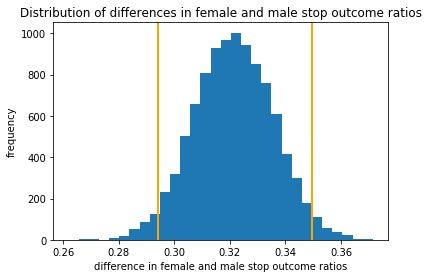

In [175]:
# plot a histogram of these values with the percentiles marked
_ = plt.hist(ratio_diffs, bins=30)
_ = plt.axvline(x=ratio_conf[0], color='orange', linewidth=2)
_ = plt.axvline(x=ratio_conf[1], color='orange', linewidth=2)
_ = plt.xlabel('difference in female and male stop outcome ratios')
_ = plt.ylabel('frequency')
_ = plt.title('Distribution of differences in female and male stop outcome ratios')

To verify these results in a more traditional manner, I used the same bootstrapping technique with difference in averages as the test statistic. In this case, since stop outcome is hot encoded (written warnings = 1, citation = 0), the average will correspond to the rate at which either group is given written warnings.

        Ho: The difference between female and male average stop outcomes is zero
        Ha: The difference between female and male average stop outcomes is not zero.

In [185]:
def draw_bootstrap_reps(data, func, size=1):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_sample = np.random.choice(data, len(data))
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

In [194]:
# define a function to calculate the test statistic
def diff_between_means(female, male):
    fem = draw_bootstrap_reps(female, np.mean, size=10000)
    male = draw_bootstrap_reps(male, np.mean, size=10000)
    return fem - male

In [195]:
np.random.seed(47)
mean_diffs = [diff_between_means(female_outcomes, male_outcomes)]

In [196]:
#calculate the 95% confidence interval of the difference of the outcome differences
mean_conf = np.percentile(mean_diffs, [2.5, 97.5])
mean_conf

array([0.04180389, 0.04934824])

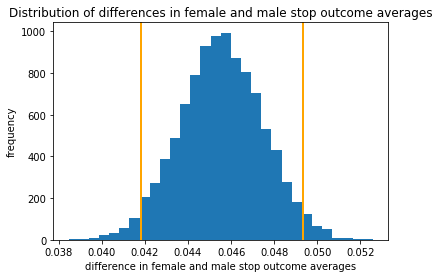

In [197]:
# plot a histogram of these values with the percentiles marked
_ = plt.hist(mean_diffs, bins=30)
_ = plt.axvline(x=mean_conf[0], color='orange', linewidth=2)
_ = plt.axvline(x=mean_conf[1], color='orange', linewidth=2)
_ = plt.xlabel('difference in female and male stop outcome averages')
_ = plt.ylabel('frequency')
_ = plt.title('Distribution of differences in female and male stop outcome averages')

The results are similar, as the 95% confidence interval does not contain 0. However, as seen in the histogram above, the difference between groups is significant, but very small. 

### Machine learning models
#### Logistic Regression

My first attempt at modeling this data was made with a logistic regression model. In order to use this model, I first ensured that all of my categorical features were converted to dummy variables or hot encoded. I then split the data into features and labels, and subsequently into training and testing sets. The model was then allowed to learn on the training data, and I gathered performance results with the testing data. A classification report is shown for the model which includes accuracy, precision, recall, and f-1 score.

In [99]:
dummies = pd.get_dummies(data_final['police_department'])
data_final = pd.concat([data_final, dummies], axis=1)

dummies = pd.get_dummies(data_final['driver_race'])
data_final = pd.concat([data_final, dummies], axis=1)

dummies = pd.get_dummies(data_final['violation'])
data_final = pd.concat([data_final, dummies], axis=1)

#drop these variables as dummy variables for these variables has been created
data_final = data_final.drop(['police_department', 'driver_race','violation'], axis=1)

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# split the data into features and labels 
data_log = data_final.copy()

# Citation == 1
data_log['stop_outcome'] = (data_log['stop_outcome'] == "Citation").astype(int)

# convert stop_date to numeric
data_log['stop_date'] = pd.to_numeric(data_log.stop_date)

y = data_log['stop_outcome']
X = data_log.drop('stop_outcome', 1)

# Split the data into a training and test set.
Xtrain, Xtest, ytrain, ytest = train_test_split(X.values, y, random_state=5)

clf = LogisticRegression()

# Fit the model on the trainng data.
clf.fit(Xtrain, ytrain)

# Print the accuracy from the testing data
print(accuracy_score(clf.predict(Xtest), ytest))


0.6150218082353811


In [112]:
from sklearn.metrics import classification_report
# pass y test and the predicted values 
ypred = clf.predict(Xtest)
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.62      1.00      0.76     41597
           1       0.00      0.00      0.00     26038

    accuracy                           0.62     67635
   macro avg       0.31      0.50      0.38     67635
weighted avg       0.38      0.62      0.47     67635



While the accuracy is high, the large class imbalance in our target variable makes precision, recall, and f-1 score more important metrics of a good model. Thus, this model performs poorly. 

#### Feature Engineering I
In an effort to improve the logistic regression model, I created a correlation matrix with the features to see if I could drop any highly correlated columns to reduce dimensionality. Any features that were less than 95% correlated were entered into a new dataframe for further model testing.

In [135]:
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [125]:
data_drop = data_log.drop(['year',
 'Asian',
 'Black',
 'Hispanic',
 'Other',
 'White',
 'Externally Generated Stop',
 'Investigatory Stop',
 'Moving Violation',
 'Suspicion of DWI',
 'Vehicle Equipment',
 'BRADFORD VSP',
 'BRATTLEBORO VSP',
 'DERBY VSP',
 'MIDDLESEX VSP',
 'NEW HAVEN VSP',
 'ROCKINGHAM VSP',
 'ROYALTON VSP',
 'RUTLAND VSP',
 'SHAFTSBURY VSP',
 'ST ALBANS VSP',
 'ST JOHNSBURY VSP',
 'VSP HEADQUARTERS - FIELD FORCE',
 'WILLISTON VSP',
 'BRADFORD VSP',
 'BRATTLEBORO VSP',
 'DERBY VSP',
 'MIDDLESEX VSP',
 'NEW HAVEN VSP',
 'ROCKINGHAM VSP',
 'ROYALTON VSP',
 'RUTLAND VSP',
 'SHAFTSBURY VSP',
 'ST ALBANS VSP',
 'ST JOHNSBURY VSP',
 'VSP HEADQUARTERS - FIELD FORCE',
 'WILLISTON VSP',
 'Asian',
 'Black',
 'Hispanic',
 'Other',
 'White',
 'BRADFORD VSP',
 'BRATTLEBORO VSP',
 'DERBY VSP',
 'MIDDLESEX VSP',
 'NEW HAVEN VSP',
 'ROCKINGHAM VSP',
 'ROYALTON VSP',
 'RUTLAND VSP',
 'SHAFTSBURY VSP',
 'ST ALBANS VSP',
 'ST JOHNSBURY VSP',
 'VSP HEADQUARTERS - FIELD FORCE',
 'WILLISTON VSP',
 'Asian',
 'Black',
 'Hispanic',
 'Other',
 'White',
 'Externally Generated Stop',
 'Investigatory Stop',
 'Moving Violation',
 'Suspicion of DWI',
 'Vehicle Equipment',
 'BRADFORD VSP',
 'BRATTLEBORO VSP',
 'DERBY VSP',
 'MIDDLESEX VSP',
 'NEW HAVEN VSP',
 'ROCKINGHAM VSP',
 'ROYALTON VSP',
 'RUTLAND VSP',
 'SHAFTSBURY VSP',
 'ST ALBANS VSP',
 'ST JOHNSBURY VSP',
 'VSP HEADQUARTERS - FIELD FORCE',
 'WILLISTON VSP',
 'Asian',
 'Black',
 'Hispanic',
 'Other',
 'White',
 'Externally Generated Stop',
 'Investigatory Stop',
 'Moving Violation',
 'Suspicion of DWI',
 'Vehicle Equipment'], axis=1)

#### Logistic Regression II: reduced dataset

Using the reduced dataset created above, I followed the same steps as above to create a new logistic regression model.

In [223]:
y = data_drop['stop_outcome']
X = data_drop.drop('stop_outcome', 1)

# Split the data into a training and test set.
Xtrain, Xtest, ytrain, ytest = train_test_split(X.values, y, random_state=5)

clf2 = LogisticRegression()

# Fit the model on the trainng data.
clf2.fit(Xtrain, ytrain)

# Print the accuracy from the testing data
print(accuracy_score(clf2.predict(Xtest), ytest))


0.6156132180084276


In [141]:
ypred = clf2.predict(Xtest)
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.62      0.99      0.76     41597
           1       0.52      0.02      0.05     26038

    accuracy                           0.62     67635
   macro avg       0.57      0.51      0.40     67635
weighted avg       0.58      0.62      0.49     67635



Though there is signficant improvement in precision (number of correct predictions for a given predicted class/ total number of predictions in same expected class), recall (number of correct predictions for given expected class / total number in expected class) still suffers with this model. Based on these results, I will continue to use the reduced dataset, but I will explore other models.

#### Random Forest Classifier I: base model

In [ ]:
# random forest , hyperparameter tuning, gradient boosting , use the smaller dataframe 

In [169]:
# Saving feature names for later use
feature_list = list(X.columns)

In [224]:
# Split the data into a training and test set.
Xtrain, Xtest, ytrain, ytest= train_test_split(X, y, test_size = 0.25, random_state=5)

In [225]:
# random forest 
# going to use the mode of the individual decision trees because its classification
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [226]:
ypred = rf.predict(Xtest)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(ytest,ypred))
print(classification_report(ytest,ypred))
print(accuracy_score(ytest, ypred))

[[28442 13155]
 [16094  9944]]
              precision    recall  f1-score   support

           0       0.64      0.68      0.66     41597
           1       0.43      0.38      0.40     26038

    accuracy                           0.57     67635
   macro avg       0.53      0.53      0.53     67635
weighted avg       0.56      0.57      0.56     67635

0.5675463887040734


Precision, recall, and f1-score greatly improved with this model, but the accuracy could be better. 

#### Feature Engineering II
In an effort to improve accuracy, I extracted a list of the features and their corresponding importances in the model and then dropped driver_gender and search_type due to low signficances.

#### Random Forest Classifier II : important features only
A second random forest classifier is trained and testing using only age, stop time, month, and weekday.

In [216]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: driver_age           Importance: 0.43
Variable: stop_time            Importance: 0.26
Variable: month                Importance: 0.17
Variable: weekday              Importance: 0.13
Variable: driver_gender        Importance: 0.01
Variable: search_type          Importance: 0.01


In [217]:
# data frame with only the top 4 features
df_rf = data_drop.drop(['driver_gender', 'search_type'], axis=1)

In [218]:
# new features and labels
y_imp = df_rf['stop_outcome']
X_imp = df_rf.drop('stop_outcome', axis=1)

# Split the data into a training and test set.
Xtrain_imp, Xtest_imp, ytrain_imp, ytest_imp = train_test_split(X_imp.values, y_imp, random_state=42)

In [219]:
# New random forest with only the four most important variables
rf_most_important = RandomForestClassifier(random_state=42)

In [220]:
# Train the random forest
rf_most_important.fit(Xtrain_imp, ytrain_imp)


ypred_imp = rf_most_important.predict(Xtest_imp)


print(confusion_matrix(ytest_imp,ypred_imp))
print(classification_report(ytest_imp,ypred_imp))
print(accuracy_score(ytest_imp, ypred_imp))

[[28376 13346]
 [16100  9813]]
              precision    recall  f1-score   support

           0       0.64      0.68      0.66     41722
           1       0.42      0.38      0.40     25913

    accuracy                           0.56     67635
   macro avg       0.53      0.53      0.53     67635
weighted avg       0.56      0.56      0.56     67635

0.5646336955718193


We see that the changes did not help, as the classifier is actually less accurate now after deletion of those features. 

#### Hyperparameter tuning with random forest classifier
Since the deletion of those two features did not improve the model, I have added them back in before performing hyperparameter tuning of the rf classifier. To do this, I used randomized search with a grid of values for 'n_estimators', 'max_features', 'max_depth', 'min_samples_split', 'min_samples_leaf', and 'bootstrap' centered around the base classifier model parameters. I performed 100 iterations with a 3 fold cross validation loop to find the best values for these parameters.

In [227]:
# hyper parameter tuning rf 
# look at the parameters being used right now 
from pprint import pprint
pprint(rf.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [230]:
from sklearn.model_selection import RandomizedSearchCV

# tune number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000]}


In [231]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(Xtrain, ytrain)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 131.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 247.5min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [232]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

#### Random Forest Classifier III: best parameters
The best parameters found from the randomized search are used in a random forest classifier and the results are compared to a base model and displayed below.

In [233]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(Xtrain, ytrain)

Model Performance
Average Error: 0.4340 degrees.
Accuracy = -inf%.


In [235]:
best_random = rf_random.best_estimator_

Model Performance
Average Error: 0.3785 degrees.
Accuracy = -inf%.


In [238]:
print('Classification report for best model')
print(classification_report(ytest,best_random.predict(Xtest)))


Classification report for best model
              precision    recall  f1-score   support

           0       0.62      0.97      0.76     41597
           1       0.57      0.07      0.12     26038

    accuracy                           0.62     67635
   macro avg       0.60      0.52      0.44     67635
weighted avg       0.60      0.62      0.51     67635



In [239]:
print('Classification report for base model')
print(classification_report(ytest,base_model.predict(Xtest)))

Classification report for base model
              precision    recall  f1-score   support

           0       0.64      0.68      0.66     41597
           1       0.43      0.38      0.40     26038

    accuracy                           0.57     67635
   macro avg       0.53      0.53      0.53     67635
weighted avg       0.56      0.57      0.56     67635



Though the accuracy improved for the "better" model, the base model maintained better values for more important metrics such as precision, recall, and f1-score.

#### Hyperparameter tuning II: grid search 
A second attempt at finding the best parameters was made with a grid search. The parameter grid values were set based on the results of the best estimator from the random search. 

#### Random forest classifier IV: grid search parameters
The resulting best parameters are fed into a random forest classifier, and the results are displayed below.

In [240]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10, 15],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [3, 5, 7],
    'n_estimators': [50, 100, 200, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [241]:
# Fit the grid search to the data
grid_search.fit(Xtrain, ytrain)
grid_search.best_params_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 81.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 180.5min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 184.7min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'n_estimators': 50}

In [242]:
best_grid = grid_search.best_estimator_

Model Performance
Average Error: 0.3777 degrees.
Accuracy = -inf%.


In [243]:
print('Classification report for Grid Search model')
print(classification_report(ytest,best_grid.predict(Xtest)))
print('Grid Search Model Accuracy')
print(accuracy_score(ytest, best_grid.predict(Xtest)))

Classification report for Grid Search model
              precision    recall  f1-score   support

           0       0.63      0.95      0.76     41597
           1       0.55      0.10      0.17     26038

    accuracy                           0.62     67635
   macro avg       0.59      0.52      0.46     67635
weighted avg       0.60      0.62      0.53     67635

Grid Search Model Accuracy
0.6223257189325053


Precision goes up, but recall and f1 are still too low.

#### Gradient Boosting Classifier
Before training this model on the data, the features were scaled. Seven different classifiers were trained and tested on training and validation data, with each classifier's learning rate parameter set to a unique value. The accuracy scores and corresponding learning rate values are displayed below.

In [244]:
# gradient boosting
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

In [245]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(Xtrain)
X_test = scaler.transform(Xtest)

In [248]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, ytrain)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, ytrain)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, ytest)))

Learning rate:  0.05
Accuracy score (training): 0.618
Accuracy score (validation): 0.615
Learning rate:  0.075
Accuracy score (training): 0.620
Accuracy score (validation): 0.617
Learning rate:  0.1
Accuracy score (training): 0.620
Accuracy score (validation): 0.618
Learning rate:  0.25
Accuracy score (training): 0.620
Accuracy score (validation): 0.618
Learning rate:  0.5
Accuracy score (training): 0.623
Accuracy score (validation): 0.621
Learning rate:  0.75
Accuracy score (training): 0.622
Accuracy score (validation): 0.621
Learning rate:  1
Accuracy score (training): 0.623
Accuracy score (validation): 0.620


Because learning rate of 0.5 lends the highest accuracy scores on both training and validation sets, this value is fed into the gradient boosting classifier.

In [249]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(X_train, ytrain)
predictions = gb_clf2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(ytest, predictions))

print("Classification Report")
print(classification_report(ytest, predictions))

Confusion Matrix:
[[39075  2522]
 [23113  2925]]
Classification Report
              precision    recall  f1-score   support

           0       0.63      0.94      0.75     41597
           1       0.54      0.11      0.19     26038

    accuracy                           0.62     67635
   macro avg       0.58      0.53      0.47     67635
weighted avg       0.59      0.62      0.53     67635



The precision is good again, but recall and f1-score still need work.

### Feature Engineering III
***Trying models without the dummy variables***

Since none of my previous attempts at optimizing the models resulted in satisfying outcomes, I am rerunning the best performing model, random forest, without dummy variables. 

To do this, I created a new dataframe with all the categorical variables back intack. I then used a label encoder to convert all of the categorical columns into integers.

In [25]:
# need to perform label encoding on the categorical columns 

# Categorical boolean mask
categorical_feature_mask = df_nodummy.dtypes == object
# filter categorical columns using mask and turn it into a list
categorical_cols = df_nodummy.columns[categorical_feature_mask].tolist()

In [26]:
# import labelencoder
from sklearn.preprocessing import LabelEncoder

# instantiate labelencoder object
le = LabelEncoder()

In [27]:
# apply le on categorical feature columns
df_nodummy[categorical_cols] = df_nodummy[categorical_cols].apply(lambda col: le.fit_transform(col))
df_nodummy[categorical_cols].head(10)

,police_department,driver_gender,driver_race,violation,stop_outcome
0,3,1,4,2,0
4,6,1,4,2,1
5,6,0,4,4,1
6,10,1,4,2,0
7,10,1,4,2,1
8,5,1,1,2,1
9,7,1,4,2,1
10,10,1,4,2,0
12,11,1,4,2,0
13,11,1,4,2,0


In [28]:
# take stop_date out since we split into other categoricals (weekday, month, year)
df_nodummy = df_nodummy.drop('stop_date',1)

#### Random forest classifier V: no dummy variables

In [29]:
# ready to start the random tree classifier
y = df_nodummy['stop_outcome']  # Labels
X = df_nodummy.drop('stop_outcome', 1)  # Features

In [30]:
# Split dataset into training set and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [31]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a random forest Classifier
clf = RandomForestClassifier(n_estimators=100)

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [53]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.656292353564476


In [62]:
from sklearn.metrics import classification_report
# pass y test and the predicted values 
ypred = clf.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.56      0.47      0.51     31135
           1       0.70      0.77      0.74     50027

    accuracy                           0.66     81162
   macro avg       0.63      0.62      0.62     81162
weighted avg       0.65      0.66      0.65     81162



This is the best performing model, with a good accuracy rate, and decent values for important metrics across the board. To visualize the models performace, and roc curve is displayed below.

In [70]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, ypred)

In [72]:
# calculate AUC
auc = roc_auc_score(y_test, ypred)
print('AUC: %.3f' % auc)

AUC: 0.620


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.688


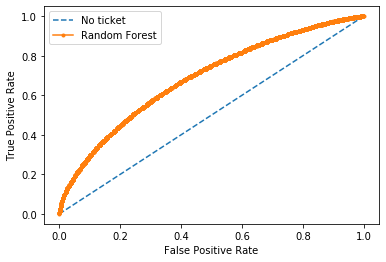

In [75]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no ticket prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome (ticket) only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No ticket')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

As a final effort to improve scores, I toggled the 'class_weight' attribute in the random forest classifier between balanced and balanced_subsample

In [36]:
# class_weight = "balanced"
#Create a random forest Classifier
clf_balanced = RandomForestClassifier(n_estimators=100, class_weight="balanced")

# Train the model using the training sets y_pred=clf.predict(X_test)
clf_balanced.fit(X_train, y_train)

y_pred = clf_balanced.predict(X_test)

In [37]:
from sklearn.metrics import classification_report
# pass y test and the predicted values 
ypred = clf_balanced.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.57      0.46      0.51     30972
           1       0.70      0.78      0.74     50190

    accuracy                           0.66     81162
   macro avg       0.63      0.62      0.62     81162
weighted avg       0.65      0.66      0.65     81162



In [36]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, ypred)

# calculate AUC
auc = roc_auc_score(y_test, ypred)
print('AUC: %.3f' % auc)

AUC: 0.618


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.689


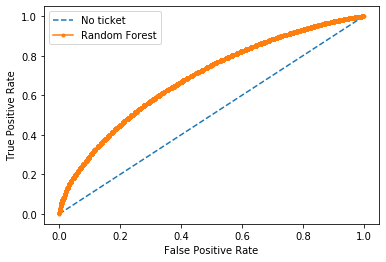

In [38]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no ticket prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = clf_balanced.predict_proba(X_test)
# keep probabilities for the positive outcome (ticket) only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No ticket')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

No improvement here. Testing class_weight="balanced_subsample"

In [33]:
# class_weight = "balanced_subsample"
#Create a random forest Classifier
from sklearn.ensemble import RandomForestClassifier

clf_balanced2 = RandomForestClassifier(n_estimators=100, class_weight="balanced_subsample")

# Train the model using the training sets y_pred=clf.predict(X_test)
clf_balanced2.fit(X_train, y_train)

y_pred = clf_balanced2.predict(X_test)

In [35]:
from sklearn.metrics import classification_report
# pass y test and the predicted values 
ypred = clf_balanced2.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.57      0.46      0.51     30972
           1       0.70      0.78      0.74     50190

    accuracy                           0.66     81162
   macro avg       0.63      0.62      0.62     81162
weighted avg       0.65      0.66      0.65     81162



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.690


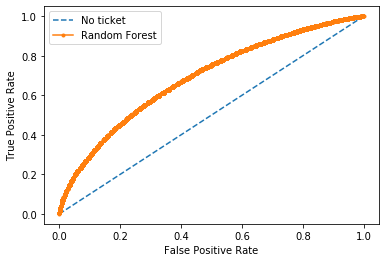

In [40]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no ticket prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = clf_balanced2.predict_proba(X_test)
# keep probabilities for the positive outcome (ticket) only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No ticket')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Since the metrics are similar, but the area under the roc curve for this classifier is the greatest, this model is chosen as my final model.